# Machine Learning Project: Assessment 2

#### Option:

If option 2, indicating who you have collaborated with on this project. 

#### Your Student ID:

#### Collaborator Student ID:

This assessment has a 70% weight.

## Case study

For this assignment you may choose to either work alone or in a pair with another student. The requirements for each are set out below.
Note that the assignments are very similar to the Data Science module, but that you are given more freedom in selecting the dataset and the use of techniques.

<font color=red>**Dataset**</font>

The choice of the datasets is free, **but please do not use the datasets discussed in the lectures. <font color=red>Do not use the irsi and MNIST dataset. </font> Here is a list of datasets, https://archive.ics.uci.edu/ml, for your reference**. Your experience in the Data Science module should allow you to pick problems that are challenging, yet manageable.  

<font color=red>**Techniques**</font>

The techniques should be the ones that are discussed in the Machine Learning unit.
Examples are: 

* Bayesian Linear Regression. For example in highlighting the differences between classical linear regression and Bayesian approaches on small dataset. Where does model uncertainty matter? What does Bayesian model selection entail and how is it used in practice.

* Bayesian Logistic Regression. Apply the Laplace approximation and then research extensions such as variational approaches.

* Use of neural networks in classification and regression tasks. Plenty of scope for interesting projects here. 

* Use of Gaussian Mixture Models, for example in the use of outlier classification. Also mixtures of other distributions such as Bernoulli can be considered.

* Use of Graphical models for classification tasks. The project should involve learning parameters and/or the structure of the model from data.

* Sampling Approaches.

* Kernel-based approaches such as SVM. For example, compare the performance of SVMs and neural networks.
 
 
### Option 1: Individual project: two techniques on a dataset 
 
More ambitious projects that build on these techniques are welcome. Projects that do not achieve their intended outcomes can be successful if plausible hypotheses for why the chosen approach did not work are provided. This provision should encourage you to seek out more interesting problems. 
The use of external software such as sklearn, pandas, R, tensorflow, PyTorch, etc. is encouraged, but should be acknowledged and the way they are used should be described accurately in the report. 
A suggestion and a warning: there are very interesting examples of data analysis projects around on the Internet. In some cases, trying to replicate this may lead to an interesting project. If you decided to go this way, you carefully have to describe the original project, where it was found and how your project sets itself apart from what you already could find on Internet. There is a clear risk of falling foul of plagiarism here. If in doubt, consult the module leader.


### Option 2: Group project: four techniques on a dataset

You can collaborate in groups of two to solve the given task if you wish; the workload must be shared equally. If you choose to be in a group then you must apply four techniques on the dataset, with each student taking on the responsibility of applying two techniques and analysing their results. The pre-processing stage must be shared
across the techniques.
Each student will submit their own individual report indicating at the top if you have collaborated with another student on this project. You will be assessed based on your individual contribution to the work, therefore you must make your contribution
clear in your submission.
The techniques we look for are as in the individual project.


## 1. Aims, objectives and plan

### a) Aims and objectives (4 marks)
Although we have already stated what is required, please formally state the aims and objectives of the project in your own words.

100-200 words

###  b) Plan (2 marks)
Please state how you have conducted the project.

50-100 words


## 2. Understanding the case study

###  Case study analysis (8 marks)
State the key points that you found in the dataset you selected and how you intend to deal with them appropriately. (You can include more than four points.)

200-300 words

1. 
2. 
3. 
4. 



## 3. Dataset description (8 marks)
Describe your dataset with enough detail, such as the number of samples. Plot an overview figure of the data with examples. Explain any pre-processing steps if there are. Please also list the reference source if it is available publicly.

100-300 words

Enter the correct code in the cells below to plot data.

In [1]:
# Plot an overview figure of the data or sample data with examples.


In [17]:
import os
import random
import shutil
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import albumentations as A

Helper functions

In [18]:
def get_img(img, augmentations=None):
    # For image loading
    # Read img file; Convert BGR -> RGB
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Apply image augmentations
    if augmentations:
        img = augmentations(image=img)['image']
    # Standardise
    return img / 255

def show_img(img):
    # For image visualisation
    # Load to cpu, detach gradient, cast to ndarray and unstandardise
    img = img.to('cpu').detach().numpy() * 255
    img = img.astype(np.uint8)
    img = np.transpose(img, (1, 2, 0))  # channels 1st -> channels last

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(img)

def seed_everything(seed):
    # For reproducibility
    # https://pytorch.org/docs/stable/notes/randomness.html
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    # Used to preserve reproducibility in DataLoader
    # https://pytorch.org/docs/stable/notes/randomness.html
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


In [19]:
def train_test_split(fungi_list, 
                     fungi_root='../data/defungi/',
                     train_end=0.65,
                     val_end=0.80):
    for i, c in enumerate(['H1', 'H2', 'H3', 'H5', 'H6']):
        fungi = np.array(fungi_list[i])

        n = len(fungi)
        indices = np.arange(n)
        train_idx = int(n * train_end)
        val_idx = int(n * val_end)

        np.random.shuffle(indices)
        train_indices = indices[:train_idx]
        val_indices = indices[train_idx:val_idx]
        trainval_indices = indices[:val_idx]
        test_indices = indices[val_idx:]

        train = fungi[train_indices]
        val = fungi[val_indices]
        trainval = fungi[trainval_indices]
        test = fungi[test_indices]

        # This shows that there is no intersection between train and test set
        print(np.intersect1d(train, val),
              np.intersect1d(trainval, test))

        for subset, path in zip([train, val, trainval, test],
                                ['train', 'val', 'trainval', 'test']):
            dst = f'{fungi_root}{path}/{c}/'
            os.makedirs(dst, exist_ok=True)
            for src in subset:
                shutil.copy(src, dst)    

def get_fungi_list(fungi_root):
    return [
        glob(f'{fungi_root}{h}/*') for h in [
            'H1', 'H2', 'H3', 'H5', 'H6'
        ]
    ]


Fungi dataset class implementation

In [20]:
class FungiDataset(Dataset):
    def __init__(self, 
                 fungi_root,
                 balance=False,
                 augmentations=None,
                 transform=None, 
                 target_transform=None):
        fungi_list = get_fungi_list(fungi_root)
        self.augmentations = augmentations
        self.transform = transform
        self.target_transform = target_transform

        if not balance:
            print('\n'.join([f'Class {i}: {len(fungi_list[i])} samples' 
                             for i in range(len(fungi_list))]))
            
            self.fungi = np.concatenate([
                np.array(h) for h in fungi_list
            ])

            # Create labels for the 5 fungi classes
            indices = [len(h) for h in fungi_list]
            self.labels = np.zeros(sum(indices))
            c1 = sum(indices[:1])
            c2 = sum(indices[:2])
            c3 = sum(indices[:3])
            c4 = sum(indices[:4])
            self.labels[c1:c2] = 1
            self.labels[c2:c3] = 2
            self.labels[c3:c4] = 3
            self.labels[c4:] = 4
        else:
            fungi = [np.array(h) for h in fungi_list]
            nfungi = [len(h) for h in fungi]
            max_nfungi = max(nfungi)
            shortage = max_nfungi - np.array(nfungi)

            augmented_fungi = []
            for idx in range(5):
                copies = np.random.choice(fungi[idx], 
                                          size=shortage[idx], 
                                          replace=True)
                augmented = np.concatenate([fungi[idx], copies])
                augmented_fungi.append(augmented)

            print('\n'.join([f'Class {i}: {len(augmented_fungi[i])} samples' 
                             for i in range(len(augmented_fungi))]))
            
            self.fungi = np.concatenate(augmented_fungi)
            self.labels = np.concatenate([
                np.zeros(max_nfungi),
                np.ones(max_nfungi),
                np.ones(max_nfungi) * 2,
                np.ones(max_nfungi) * 3,
                np.ones(max_nfungi) * 4,
            ])

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img = get_img(self.fungi[idx], augmentations=self.augmentations)
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)

        return img, label


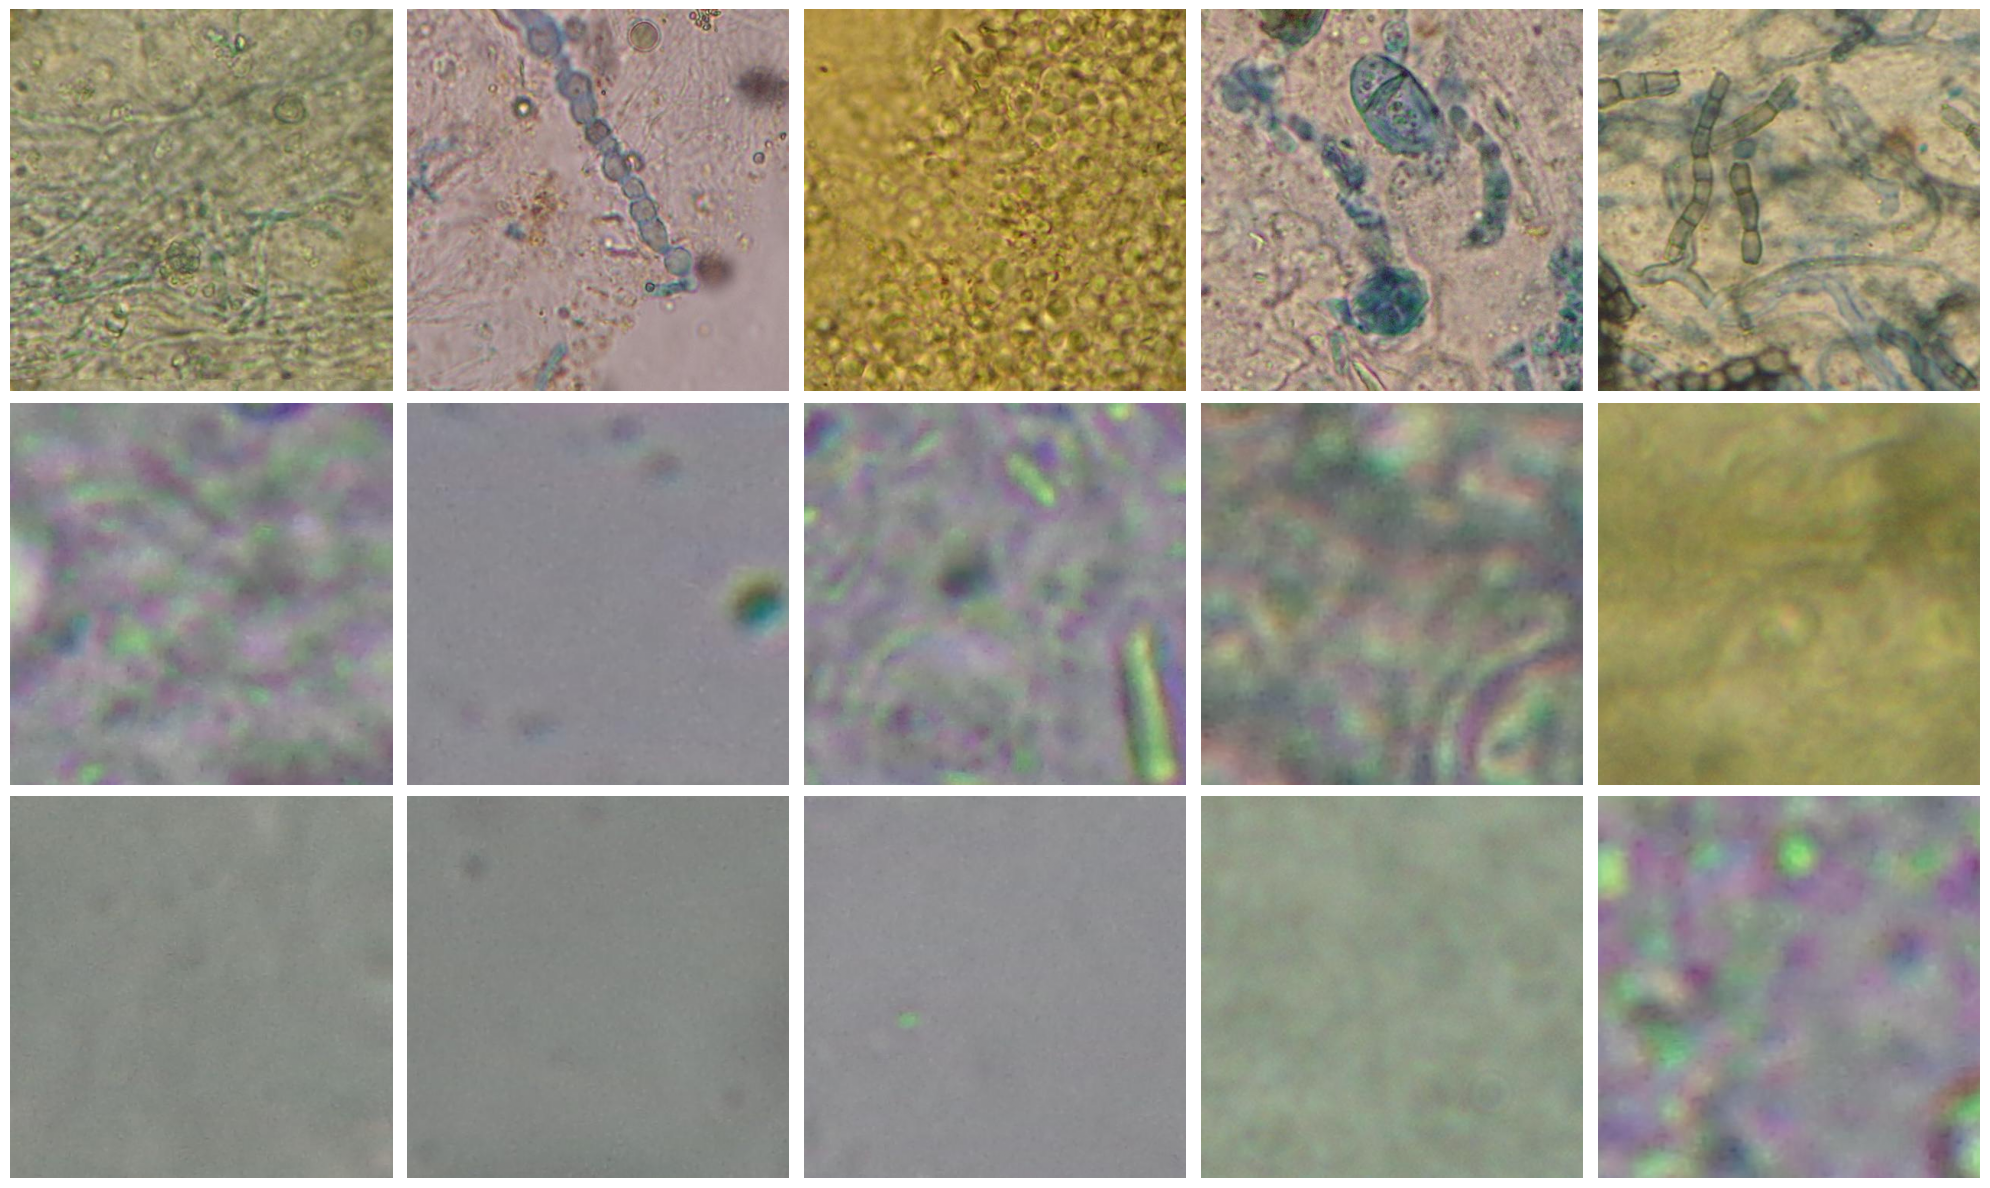

In [21]:
h1_good = get_img('../data/defungi/trainval/H1/H1_224a_1.jpg')
h1_ok = get_img('../data/defungi/trainval/H1/H1_7c_7.jpg')
h1_bad = get_img('../data/defungi/trainval/H1/H1_111a_13.jpg')

h2_good = get_img('../data/defungi/trainval/H2/H2_108a_1.jpg')
h2_ok = get_img('../data/defungi/trainval/H2/H2_13a_8.jpg')
h2_bad = get_img('../data/defungi/trainval/H2/H2_12a_7.jpg')

h3_good = get_img('../data/defungi/trainval/H3/H3_15a_2.jpg')
h3_ok = get_img('../data/defungi/trainval/H3/H3_1a_25.jpg')
h3_bad = get_img('../data/defungi/trainval/H3/H3_1a_31.jpg')

h5_good = get_img('../data/defungi/trainval/H5/H5_14a_3.jpg')
h5_ok = get_img('../data/defungi/trainval/H5/H5_15a_1.jpg')
h5_bad = get_img('../data/defungi/trainval/H5/H5_105a_5.jpg')

h6_good = get_img('../data/defungi/trainval/H6/H6_24a_2.jpg')
h6_ok = get_img('../data/defungi/trainval/H6/H6_70a_5.jpg')
h6_bad = get_img('../data/defungi/trainval/H6/H6_2a_5.jpg')

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
images = [[h1_good, h2_good, h3_good, h5_good, h6_good],
          [h1_ok, h2_ok, h3_ok, h5_ok, h6_ok],
          [h1_bad, h2_bad, h3_bad, h5_bad, h6_bad]]

for i in range(3):
    for j in range(5):
        axes[i][j].axis('off')
        axes[i][j].imshow(images[i][j])

plt.tight_layout()
plt.show()

The DeFungi dataset, used in this project, contains images of microscopic fungi. 

Overall the dataset contains 9114 3-channel RGB images of size 500X500.

Images are labelled into five classes which are unbalanced:
1) Class H1: 4404 samples
2) Class H2: 2334 samples
3) Class H3: 819 samples
4) Class H5: 818 samples
5) Class H6: 739 samples

Significant number of images are of low or poor quality: blurred images, chromatic aberrations, and images containing no objects.

On the figure above 3 samples are given for each of the 5 classes:
1) Top row: examples of good samples
2) Middle row: Examples of low-quality samples
3) Bottom row: Examples of poor-quality samples

Class H6, although the most underrepresented one, contains more high-quality images proportionally than the other classes, while the firts 2 classes - H1 and H2 - are more represented, but have larger portion of low-quality samples.

Images are very diverse in terms scale: some of them capture a large number of fungi, while others zoom-in on just a few fungi. Example of this particularity is demonstrated in the figure below:

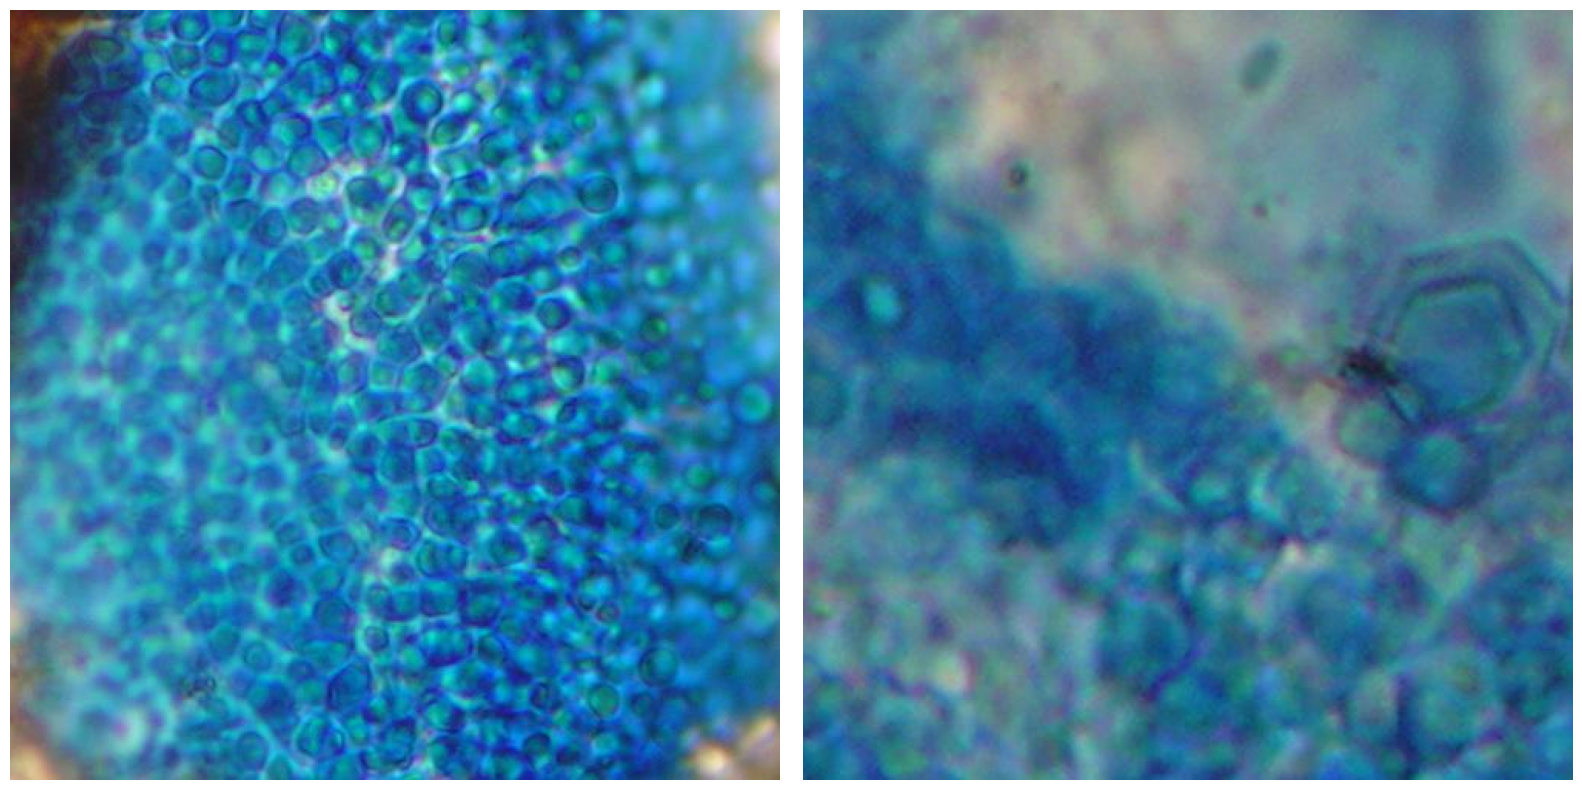

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

img1 = get_img('../data/defungi/trainval/H3/H3_36a_3.jpg')
img2 = get_img('../data/defungi/trainval/H3/H3_20a_1.jpg')

axes[0].imshow(img1)
axes[1].imshow(img2)
axes[0].axis('off')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [25]:
FUNGI_ROOT = '../data/defungi/'
EPOCHS = 10
BATCH_SIZE = 16
NUM_WORKERS = 12

SEED = 42
seed_everything(SEED)

In [26]:
# Splits data into train and test subsets
# Copies files into train/ & test/ subdirectories
train_test_split(get_fungi_list(FUNGI_ROOT), 
                 fungi_root=FUNGI_ROOT, 
                 train_end=0.65,
                 val_end=0.80)

[] []
[] []
[] []
[] []
[] []


## 4. Technique (part 1)

### a) Discuss your motivation for choosing the technique and provide a schematic figure of the process (8 marks)

100-200 words


The first technique chosen is the Support Vector Machine classifier, which is a widely used approach for classification tasks.

Although it is implemented in *scikit-learn* library, pytorch implementation is used here. The reason for this is that *sklearn* implementation of SVM requires all data to be fed into the model simultaniously and computations are conducted in float64 format, resulting in 33GB RAM requirements for SVM training. Pytorch implementation provided uses Linear layer in combination with MultiMarginLoss (hinge loss) and L2 regularisation and is optimised using Stochastic Gradient Descent.

Model training and evaluating functions

In [10]:
class SVM(nn.Module):
    def __init__(self, input_size, num_classes, c):
        super().__init__()
        self.c = c
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.fc(x)
    

def train_run_svm(model_,
                  epochs_,
                  lr,
                  train_dataloader_,
                  print_every_n_minibatches=100):
    optimizer = torch.optim.SGD(model_.parameters(), lr=lr)
    criterion = torch.nn.MultiMarginLoss()

    for epoch in range(epochs_):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_dataloader_, 0):
            images = images.to('cuda', dtype=torch.float)
            labels = labels.to('cuda', dtype=torch.int64)

            optimizer.zero_grad()
            predictions = model_(images)
            loss = criterion(input=predictions, target=labels)
            
            w = model_.fc.weight.squeeze()
            loss += model_.c * (w**2).sum() / 2.0

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if not(i % print_every_n_minibatches) and i:
                print(f'EPOCH {epoch}: TRAIN_LOSS={running_loss/(i + 1):.5f}')


def performance_measures(y_true, y_pred,
                         print_=False,
                         confusion_mat=False,
                         cls_report=False):

    pr = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    re = recall_score(y_true=y_true, y_pred=y_pred, average='macro')

    if print_:
        print(f'Precision: {pr}')
        print(f'Recall: {re}')
    if confusion_mat:
        cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
        cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
        cmd.plot()
        plt.show()
    if cls_report:
        crep = classification_report(y_true=y_true, y_pred=y_pred)
        print(crep)


Enter the correct code in the cells below to execute each of the stated sub-tasks.
### b) Setting hyper parameters (rationale) (5 marks)


### c) Optimising hyper parameters (5 marks) 


### d) Performance metrics for training (5 marks)

## 5. Technique (part 2)

### a) Discuss your motivation for choosing the technique and  provide a schematic figure of the process (8 marks)

100-200 words


The second technique chosen is a Convolutional Neural Network. CNNs have been a superior approach to image processing problems

Model training and evaluating functions

In [9]:
def train_run(model_,
              optimizer_,
              criterion_,
              epochs_, 
              train_dataloader_,
              val_dataloader_,
              val_every_n_minibatches=100):
    history = {
        'train_loss': [],
        'val_loss': [],
    }

    model_.train()
    for epoch in range(epochs_):
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_dataloader_, 0):
            images = images.to('cuda', dtype=torch.float)
            labels = labels.to('cuda', dtype=torch.int64)

            optimizer_.zero_grad()

            predictions = model_(images)
            loss = criterion_(input=predictions, target=labels)
            loss.backward()
            optimizer_.step()

            running_loss += loss.item()

            # Validate every val_every_n_minibatches mini-batches
            if not(i % val_every_n_minibatches) and i:
                model_.eval()
                with torch.no_grad():
                    val_loss = 0.0
                    for j, (val_images, val_labels) in enumerate(val_dataloader_, 0):
                        val_images = val_images.to('cuda', dtype=torch.float)
                        val_labels = val_labels.to('cuda', dtype=torch.int64)
                        val_predictions = model_(val_images)
                        loss = criterion_(input=val_predictions, target=val_labels)
                        val_loss += loss.item()
                val_loss /= len(val_dataloader_)
                history['val_loss'].append(val_loss)
                history['train_loss'].append(running_loss/(i + 1))
                print(f'EPOCH {epoch}: TRAIN_LOSS={running_loss/(i + 1):.5f}'
                      + f' VAL_LOSS={val_loss:.5f}')
                model_.train()

    return history


def predict(model_, dataloader):
    y_true = []
    y_pred = []

    model_.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to('cuda', dtype=torch.float)
            labels = labels.to('cuda', dtype=torch.int64)

            predictions = model_(images)
            _, predictions = torch.max(predictions.data, dim=1)
            
            predictions = predictions.to('cpu').detach().numpy()
            labels = labels.to('cpu').detach().numpy()
            
            y_pred.append(predictions)
            y_true.append(labels)        

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return y_pred, y_true


def plot_train_val_loss(history):
    plt.plot(np.arange(len(history['train_loss'])),
             history['train_loss'], 
             label='Train Loss')
    plt.plot(np.arange(len(history['val_loss'])),
             history['val_loss'], 
             label='Val Loss')
    plt.legend()
    plt.show()
    

CNN class implementation

In [16]:
class ConvNet(nn.Module):
    def __init__(self, fc_size=512, k_size=3):
        super().__init__()
        self.conv1 = self.conv(in_channels=3, out_channels=8, k_size=k_size)
        self.conv2 = self.conv(in_channels=8, out_channels=16, k_size=k_size)
        self.conv3 = self.conv(in_channels=16, out_channels=32, k_size=k_size)
        self.conv4 = self.conv(in_channels=32, out_channels=64, k_size=k_size)
        self.conv5 = self.conv(in_channels=64, out_channels=128, k_size=k_size)
        self.conv6 = self.conv(in_channels=128, out_channels=128, k_size=k_size)
        self.conv7 = self.conv(in_channels=128, out_channels=128, k_size=k_size)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(3**2 * 128, fc_size)
        self.fc2 = nn.Linear(fc_size, 5)
    
    def conv(self, in_channels, out_channels, k_size):
        return nn.Conv2d(in_channels=in_channels,
                         out_channels= out_channels,
                         kernel_size=k_size, 
                         padding='same')
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

Enter the correct code in the cells below to execute each of the stated sub-tasks.
### b) Setting hyper parameters (rationale) (5 marks)


In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=(-0.25, 0.25),
        scale_limit=(-0.5, 0.5),
        rotate_limit=(-180, 180),
        p=0.9,
    ),
    A.Blur(blur_limit=5),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
])


### c) Optimising hyper parameters (5 marks)


In [ ]:
try diff linear layers confing
+ smth else
+ lr

### d) Performance metrics for training (5 marks)

## 6. Comparison of metrics performance for testing 
Enter the correct code in the cells below to execute each of the stated sub-tasks. 


### a) Examining over-fitting (4 marks)

### b) Comparison with appropriate metrics for testing (4 marks)

### c) Model selection (4 marks)

## 7. Final recommendation of best model

### a) Discuss the results from a technical perspective, for example, overfitting discussion, complexity and efficiency (4 marks)

100-200 words


### b) Discuss the results from a business perspective, for example, results interpretation, relevance and balance with technical perspective (4 marks)

100-200 words

## 8. Conclusion

### a) What has been successfully accomplished and what has not been successful? (4 marks)
100-300 words

### b) Reflecting back on the analysis, what could you have done differently if you were to do the project again? (4 marks)

100-300 words

### c) Provide a wish list of future work that you would like to do (4 marks)

100-300 words